## NeRF: Neural Radience Field

The code is borrowed from https://github.com/kwea123/nerf_pl, https://github.com/yenchenlin/nerf-pytorch

![](https://github.com/bmild/nerf/raw/master/imgs/pipeline.jpg)

In [22]:
import json
import os

import imageio 
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import IPython.display as disp

from PIL import Image
from torchvision import transforms
from tqdm import tqdm
path = '/content/drive/MyDrive/Colab Notebooks/'

# Ray generation and point sampling

In [23]:
def create_meshgrid(height,
                    width,
                    normalized_coordinates = True,
                    device = torch.device('cpu'),
                    dtype = torch.float32,
                   ):
    
    xs = torch.linspace(0, width - 1, width, device=device, dtype=dtype)
    ys = torch.linspace(0, height - 1, height, device=device, dtype=dtype)
    
    if normalized_coordinates:
        xs = (xs / (width - 1) - 0.5) * 2
        ys = (ys / (height - 1) - 0.5) * 2
    # generate grid by stacking coordinates
    base_grid = torch.stack(torch.meshgrid([xs, ys]), dim=-1)  # WxHx2
    return base_grid.permute(1, 0, 2).unsqueeze(0)  # 1xHxWx2

In [24]:
def get_rays_with_dir(directions, c2w):
    """
    Get ray origin and normalized directions in world coordinate for all pixels in one image.
    Inputs:
        directions: (H, W, 3) precomputed ray directions in camera coordinate
        c2w: (3, 4) transformation matrix from camera coordinate to world coordinate
    Outputs:
        rays_o: (H*W, 3), the origin of the rays in world coordinate
        rays_d: (H*W, 3), the normalized direction of the rays in world coordinate
    """
    # Rotate ray directions from camera coordinate to the world coordinate
    rays_d = directions @ c2w[:, :3].T # (H, W, 3)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    # The origin of all rays is the camera origin in world coordinate
    rays_o = c2w[:, 3].expand(rays_d.shape) # (H, W, 3)

    rays_d = rays_d.view(-1, 3) # (H * W, 3)
    rays_o = rays_o.view(-1, 3)

    return rays_o, rays_d

In [25]:
def get_ray_directions(H, W, focal):
    """
    Get ray directions for all pixels in camera coordinate.
    Reference: https://www.scratchapixel.com/lessons/3d-basic-rendering/
               ray-tracing-generating-camera-rays/standard-coordinate-systems
    Inputs:
        H, W, focal: image height, width and focal length
    Outputs:
        directions: (H, W, 3), the direction of the rays in camera coordinate
    """
    grid = create_meshgrid(H, W, normalized_coordinates=False)[0]
    i, j = grid.unbind(-1)
    # the direction here is without +0.5 pixel centering as calibration is not so accurate
    # see https://github.com/bmild/nerf/issues/24
    directions = \
        torch.stack([(i-W/2)/focal, -(j-H/2)/focal, -torch.ones_like(i)], -1) # (H, W, 3)

    return directions

In [26]:
class BlenderDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', img_wh = (750, 1000)):
        self.root_dir = root_dir
        self.split = split
        self.img_wh = img_wh
        
        self.transform = transforms.ToTensor()
      
        # bounds, common for all scenes
        self.near = 1.0
        self.far = 32.0
        self.bounds = np.array([self.near, self.far])
        
        self.white_back = False
        
        with open(os.path.join(self.root_dir, f"transforms_{self.split}.json"), 'r') as f:
            self.meta = json.load(f)

        
        self.focal = 0.5*750/np.tan(0.5*self.meta['camera_angle_x']) # original focal length
                                                                     # when W=800
        self.focal *= self.img_wh[0] /750 # modify focal length to match size self.img_size
        
        H = img_wh[0]
        W = img_wh[1]
        
        self.dir_cam = get_ray_directions(W, H, self.focal)
            
        if self.split == 'train': # create buffer of all rays and rgb data
            self.image_paths = []
            self.poses = []
            self.all_rays = []
            self.all_rgbs = []
            for frame in self.meta['frames']:
                pose = np.array(frame['transform_matrix'])[:3, :4]
                self.poses += [pose]
                c2w = torch.FloatTensor(pose)

                image_path = os.path.join(self.root_dir, f"{frame['file_path']}")
                self.image_paths += [image_path]
                img = Image.open(image_path)
                img = img.resize((H, W), Image.LANCZOS)
                img = self.transform(img) # (4, h, w)
                img = img.view(4, -1).permute(1, 0) # (h*w, 4) RGBA -> (640000, 4)
                img = img[:, :3]*img[:, -1:] + (1-img[:, -1:]) # blend A to RGB -> (h*w, 3)
                self.all_rgbs += [img]
                
                rays_o, rays_d = get_rays_with_dir(self.dir_cam, c2w) # both (h*w, 3)

                self.all_rays += [torch.cat([rays_o, rays_d, 
                                             self.near*torch.ones_like(rays_o[:, :1]),
                                             self.far*torch.ones_like(rays_o[:, :1])],
                                             1)] # (h*w, 8)
            '''
            flatten all rays/rgb tensor
                * self.all_rgbs[idx] -> (r,g,b)
                * self.all_rays[idx] -> (ox,oy,oz,dx,dy,dz,near,far)
            '''
            self.all_rays = torch.cat(self.all_rays, 0) # (len(self.meta['frames])*h*w, 8) -> (100x800x800, 8)
            self.all_rgbs = torch.cat(self.all_rgbs, 0) # (len(self.meta['frames])*h*w, 3) -> (100x800x800, 3)
            
    def __len__(self):
        if self.split == 'train':
            return len(self.all_rays)
        if self.split == 'val':
            return 6
        return len(self.meta['frames'])

    def __getitem__(self, idx):
        if self.split == 'train': # use data in the buffers
            return self.all_rays[idx], self.all_rgbs[idx]

        else: # create data for each image separately
            frame = self.meta['frames'][idx]
            c2w = torch.FloatTensor(frame['transform_matrix'])[:3, :4]

            img = Image.open(os.path.join(self.root_dir, f"{frame['file_path']}"))
            img = img.resize((self.img_wh[0], self.img_wh[1]), Image.LANCZOS)
            img = self.transform(img) # (4, H, W)
            img = img.view(4, -1).permute(1, 0) # (H*W, 4) RGBA
            img = img[:, :3]*img[:, -1:] + (1-img[:, -1:]) # blend A to RGB

            rays_o, rays_d = get_rays_with_dir(self.dir_cam, c2w)

            rays = torch.cat([rays_o, rays_d, 
                              self.near*torch.ones_like(rays_o[:, :1]),
                              self.far*torch.ones_like(rays_o[:, :1])],
                              1) # (H*W, 8)
            
        return rays, img

In [27]:
def sample_points_from_rays(ray_count, num_samples, near, far, device, lindisp = False):
    """
    Inputs:
        ray_count: int, number of rays in input ray chunk
        near: float or array of shape [BatchSize]. Nearest distance for a ray.
        far: float or array of shape [BatchSize]. Farthest distance for a ray.
    Outputs:
        point_intervals: (ray_count, self.num_samples) : depths of the sampled points along the ray
    """
    #Process near and far to match the output size
    if not hasattr(near, 'shape') and isinstance (near, float):
        near, far = near * torch.ones_like(torch.empty(ray_count,1)), far * torch.ones_like(torch.empty(ray_count,1))
    elif len(near.shape) > 0 and near.shape[0] == ray_count:
        near, far = near[:, None], far[:, None]
    
    #Apply broadcasting to create fixed intervals for all rays
    point_intervals = torch.linspace(0.0, 1.0, num_samples, device = device)[None, :]
    if lindisp:
        point_intervals = 1 / (1 / near * (1.0 - point_intervals) + 1 / far * point_intervals)
    else:
        point_intervals = near * (1.0 - point_intervals) + far * point_intervals
    
    # Get intervals between samples.
    mids = 0.5 * (point_intervals[..., 1:] + point_intervals[..., :-1])
    upper = torch.cat((mids, point_intervals[..., -1:]), dim = -1)
    lower = torch.cat((point_intervals[..., :1], mids), dim = -1)

    # Stratified samples in those intervals.
    t_rand = torch.rand(point_intervals.shape, dtype = point_intervals.dtype, device = point_intervals.device)
    point_intervals = lower + (upper - lower) * t_rand

    point_intervals = torch.reshape(point_intervals, (ray_count,-1)) # reshape for sanity
    
    return point_intervals

def sample_pdf(bins, weights, N_importance, det=False, eps=1e-5):
    """
    Sample @N_importance samples from @bins with distribution defined by @weights.
    Inputs:
        bins: (N_rays, N_samples_+1) where N_samples_ is "the number of coarse samples per ray - 2"
        weights: (N_rays, N_samples_)
        N_importance: the number of samples to draw from the distribution
        det: deterministic or not
        eps: a small number to prevent division by zero
    Outputs:
        samples: the sampled samples
    """
    N_rays, N_samples_ = weights.shape
    weights = weights + eps # prevent division by zero (don't do inplace op!)
    pdf = weights / torch.sum(weights, -1, keepdim=True) # (N_rays, N_samples_)
    cdf = torch.cumsum(pdf, -1) # (N_rays, N_samples), cumulative distribution function
    cdf = torch.cat([torch.zeros_like(cdf[: ,:1]), cdf], -1)  # (N_rays, N_samples_+1) 
                                                               # padded to 0~1 inclusive

    if det:
        u = torch.linspace(0, 1, N_importance, device=bins.device)
        u = u.expand(N_rays, N_importance)
    else:
        u = torch.rand(N_rays, N_importance, device=bins.device)
    u = u.contiguous()

    inds = torch.searchsorted(cdf, u, right = True)
    below = torch.clamp_min(inds-1, 0)
    above = torch.clamp_max(inds, N_samples_)

    inds_sampled = torch.stack([below, above], -1).view(N_rays, 2*N_importance)
    cdf_g = torch.gather(cdf, 1, inds_sampled).view(N_rays, N_importance, 2)
    bins_g = torch.gather(bins, 1, inds_sampled).view(N_rays, N_importance, 2)

    denom = cdf_g[...,1]-cdf_g[...,0]
    denom[denom<eps] = 1 # denom equals 0 means a bin has weight 0, in which case it will not be sampled
                         # anyway, therefore any value for it is fine (set to 1 here)

    samples = bins_g[...,0] + (u-cdf_g[...,0])/denom * (bins_g[...,1]-bins_g[...,0])
    return samples

#Volume rendering

![](https://github.com/bmild/nerf/raw/master/imgs/pipeline.jpg)

The expected color $С(\mathbf{r})$ of camera ray $\mathbf{r}(t) = \mathbf{o} + t\mathbf{d}$ with near and far bounds $t_n$ and $t_f$ is:

$C(\mathbf{r})=\int_{t_{n}}^{t_{f}} T(t) \sigma({r}(t)) {c}({r}(t), {d}) d t$, 
where $T(t)=\exp \left(-\int_{t_{n}}^{t} \sigma({r}(s)) d s\right)$.
Informally $T(t)$ is the probability that the ray goes on and doesn't hit anything,  $\sigma({r}(t))$ shows how much ray stopped at current point.

The integral using quadrature with finite number of points:

$\hat{C}(\mathbf{r}) = \sum_{i = 1}^N T_i \alpha_i \mathbf{c}_i$, where $T_i = exp(-\sum_{j = 1}^{i - 1} \sigma_j \delta_j),\; \alpha_i = (1 - \exp(-\sigma_i \delta_i))$


In [28]:
def volume_rendering(radiance_field, depth_values, ray_directions, use_white_bkg = True):
        """
        Perform volume rendering by computing the output of NeRF model 
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma 
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3) 
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray
        """
        
        # distance between adjacent samples points.
        deltas = torch.cat(
            (depth_values[..., 1:] - depth_values[..., :-1], 
             torch.tensor([1e10], device = depth_values.device).expand(depth_values[..., :1].shape)),
             dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        sigmas = F.softplus(radiance_field[..., 3])

        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # Cumulative product: [a, b, c, d] -> [1, a, a * b, a * b * c]
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        weights = alpha * T_i  # (ray_count, num_samples)
        rgb_map = weights[..., None] * rgb  # (ray_count, num_samples, 3)
        # sum over rgb value of each sample points (sum_over R,sum_over G, sum_over B) along the ray
        rgb_map = rgb_map.sum(dim=-2)  # (ray_count, 3)

        # sum over weight of each ray (if ray has met any object)
        acc_map = weights.sum(dim=-1)  # (ray_count, )

        if use_white_bkg:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map, weights


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.
    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, -1)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, -1)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.0

    return cumprod

# Network



![](https://miro.medium.com/max/1129/1*q3fLvJFfoUdtVhsXeeTNXw.png)

In [29]:
class Embedder(nn.Module):
    """
    Defines a function that embeds x to (x, sin(2^k x), cos(2^k x), ...) 
    (Different from the paper, prepend input 'x' by default)
    Args:
        input_channels (int): number of input channels
        num_freqs (int): `L_d=4` for viewing direcion, `L_x=10` for 3D-coordinate  
    """

    def __init__(self, input_channels, num_freqs, ):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.input_channels = input_channels
        self.sin_and_cos = [torch.sin, torch.cos]
        self.output_channels = input_channels * (2 * num_freqs + 1)
        self.freq_bands = torch.linspace(1, 2 ** (num_freqs-1), num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (ray_cnt, num_sample, self.in_channels)
        Outputs:
            out: (ray_cnt, num_sample, self.out_channels)
        """
        out = [x]
        for freq in self.freq_bands:
            for func in self.sin_and_cos:
                out += [func(freq * x)]

        return torch.cat(out, -1)

In [30]:
class RFNetwork(nn.Module):
    def __init__(self, net_depth=8, net_width=256, in_channels_xyz=63, in_channels_dir=27, skips=[4]):
        """
        net_depth: number of layers for density (sigma) encoder
        net_width: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super(RFNetwork, self).__init__()
        self.net_depth = net_depth
        self.net_width = net_width
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(self.net_depth):
            if i == 0:
                layer = nn.Linear(self.in_channels_xyz, self.net_width)
            elif i in skips:
                layer = nn.Linear(self.in_channels_xyz + self.net_width,self.net_width)
            else:
                layer = nn.Linear(self.net_width,  self.net_width)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(self.net_width, self.net_width)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
            nn.Linear(self.in_channels_dir + self.net_width,  self.net_width//2),
            nn.ReLU(True),
        )

        # output layers
        self.sigma = nn.Linear(self.net_width, 1)
        self.rgb = nn.Sequential(nn.Linear(self.net_width//2, 3),
                                 nn.Sigmoid())

    def forward(self, x):
        """
        Encodes input (xyz+dir) to rgb+sigma
        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
        Outputs:
                out: (B, 4), rgb and sigma
        """
        #Split the input
        input_xyz, input_dir = torch.split(x, [self.in_channels_xyz, self.in_channels_dir], dim=-1)

        #Process positional features
        xyz_ = input_xyz
        for i in range(self.net_depth):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        #Predict sigma for positional features
        sigma = self.sigma(xyz_)

        #Predict rgb for positional and directional features
        xyz_encoding_final = self.xyz_encoding_final(xyz_)
        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)
        
        out = torch.cat([rgb, sigma], dim=-1)
        return out

# Model

In [31]:
class NeRF(nn.Module):
    def __init__(self, N_samples, N_importance, device, lindisp = False, use_white_bkgd = True):
        super(NeRF, self).__init__()

        self.N_samples = N_samples
        self.N_importance = N_importance
        self.lindisp = lindisp
        self.use_white_bkgd = use_white_bkgd
        self.device = device
        
        self.embedder_xyz = Embedder(input_channels=3, num_freqs=10)
        self.embedder_dir = Embedder(input_channels=3, num_freqs=4)
        self.embeddings = {'xyz': self.embedder_xyz, 'dir': self.embedder_dir}

        self.coarse_network = RFNetwork()
        self.fine_network = RFNetwork()

    def forward(self, ray_batch):
        """ Does a prediction for a batch of rays.
        Args:
            ray_batch: (N_rays, 3) Tensor of camera rays containing position, direction and bounds.
            
        Returns: Tensor with the calculated pixel value for each ray.
        """
        
        N_rays = ray_batch.shape[0]
        N_samples = self.N_samples

        # both (N_rays, 3)
        ray_origins, ray_directions = ray_batch[:, 0:3], ray_batch[:, 3:6]
        # both (N_rays, 1)
        near, far = ray_batch[:, 6:7], ray_batch[:, 7:8]
        
        ### POINT SAMPLING
        #Predict depths for every ray (depth is 1D coordinate from ray)
        ray_depth_values = sample_points_from_rays(N_rays, N_samples, near, far, self.device, self.lindisp)
        
        # Samples across each ray (N_rays, N_sample, 3)
        ray_points = ray_origins[..., None, :] + ray_directions[..., None, :] * ray_depth_values[..., :, None]

        # Expand rays to match batch size
        expanded_rays_dir = ray_directions[..., None, :].expand_as(ray_points)
        
        ###COARSE RADIANCE FIELD PREDICTION
        # Flatten the first two dimensions -> (N_rays * N_samples, 3)
        xyz_ = ray_points.view(-1, 3)  # (N_rays*N_samples_, 3)
        expanded_rays_dir = expanded_rays_dir.contiguous() 
        expanded_rays_dir_ = expanded_rays_dir.view(-1, 3) # (N_rays*N_samples_, 3)

        xyz_embedded = self.embedder_xyz(xyz_)  # (N_rays*N_samples_, 63)
        # (N_rays*N_samples_, 27)
        dir_embedded = self.embedder_dir(expanded_rays_dir_)

        xyzdir_embedded = torch.cat((xyz_embedded, dir_embedded), dim=-1).to(self.device)
        
        # Predict radiance field for ray_points width ray_directions using RFNetwork
        radiance_field = self.coarse_network(xyzdir_embedded)
        radiance_field = torch.reshape(radiance_field, (N_rays, N_samples, -1)).to(self.device)
        
        
        ###COARSE VOLUME RENDERING
        rgb_coarse, weights_coarse = volume_rendering(radiance_field, ray_depth_values, ray_directions, self.use_white_bkgd)
        
        
        ###Hierarcial sampling
        ray_depth_values_mid = 0.5 * (ray_depth_values[: ,:-1] + ray_depth_values[: ,1:]) # (N_rays, N_samples-1) interval mid points
        ray_depth_values_ = sample_pdf(ray_depth_values_mid, weights_coarse[:, 1:-1],
                             self.N_importance, det=False).detach()
                  # detach so that grad doesn't propogate to weights_coarse from here

        ray_depth_values, _ = torch.sort(torch.cat([ray_depth_values, ray_depth_values_], -1), -1)
        xyz_fine_sampled = ray_origins[..., None, :] + ray_directions[..., None, :] * ray_depth_values[..., :, None]
                           # (N_rays, N_samples+N_importance, 3)
            
        expanded_rays_dir = ray_directions[..., None, :].expand_as(xyz_fine_sampled)
        
        ###FINE RADIANCE FIELD PREDICTION
        # Flatten the first two dimensions -> (N_rays * N_samples, 3)
        xyz_fine_ = xyz_fine_sampled.view(-1, 3)  # (N_rays*N_samples_, 3)
        expanded_rays_dir = expanded_rays_dir.contiguous() 
        expanded_rays_dir_ = expanded_rays_dir.view(-1, 3) # (N_rays*N_samples_, 3)

        xyz_fine_embedded = self.embedder_xyz(xyz_fine_)  # (N_rays*N_samples_, 63)
        # (N_rays*N_samples_, 27)
        dir_fine_embedded = self.embedder_dir(expanded_rays_dir_)

        xyzdir_fine_embedded = torch.cat((xyz_fine_embedded, dir_fine_embedded), dim=-1).to(self.device)
        
        # Predict radiance field for ray_points width ray_directions using RFNetwork
        radiance_field_fine = self.fine_network(xyzdir_fine_embedded)
        radiance_field_fine = torch.reshape(radiance_field_fine, (N_rays, self.N_samples + self.N_importance, -1)).to(self.device)
        
        
        ###FINE VOLUME RENDERING
        rgb_fine, weights_fine = volume_rendering(radiance_field_fine, ray_depth_values, ray_directions, self.use_white_bkgd)

        return rgb_coarse, rgb_fine

In [32]:
def psnr(mse):
    return -10*torch.log10(mse)

In [33]:
batch_size = 4096
img_wh = (375, 500)
chunk_size = 4 * 1024
lrate_decay = 500
decay_rate = 0.1
decay_steps = lrate_decay * 1000

In [34]:
model = NeRF(N_samples = 256, N_importance = 128, device = 'cuda', lindisp = True, use_white_bkgd= False).to('cuda')

In [35]:
optimizer = torch.optim.Adam(list(model.coarse_network.parameters()) + list(model.fine_network.parameters()), lr=5e-4, betas=(0.9, 0.999))

In [36]:
criterion = nn.MSELoss(reduction='mean')

In [37]:
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/3D/')
current_path = os.getcwd()
print(current_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/3D


In [38]:
#train_dataset = BlenderDataset('./images', split='train', img_wh = img_wh)
val_dataset = BlenderDataset('.', split='val', img_wh = img_wh)

In [39]:
#train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=5, batch_size=batch_size, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, num_workers=5, batch_size=1, pin_memory=True)

#Animation generation

In [40]:
model.load_state_dict(torch.load('pretrained_nerf_crow.pth'))

<All keys matched successfully>

In [41]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor([
         [1,0,0,-0.29],
        [0,1,0,-0.38],
        [0,0,1,t - 2.],
        [0,0,0,1]], dtype=torch.float)

def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor([
        [1,0,0,0],
        [0,torch.cos(phi),-torch.sin(phi),0],
        [0,torch.sin(phi), torch.cos(phi),0],
        [0,0,0,1]], dtype=torch.float)

def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor([
        [torch.cos(theta),0,-torch.sin(theta),0],
        [0,1,0,0],
        [torch.sin(theta),0, torch.cos(theta),0],
        [0,0,0,1]], dtype=torch.float)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


In [42]:
model = model.train(False)
frames = []
for th in tqdm(np.linspace(0., 360., 50, endpoint=False)):
    c2w = pose_spherical(th, -35., 5.8)
    
    rays_o, rays_d = get_rays_with_dir(val_dataset.dir_cam, c2w[:3, :4])
    rays = torch.cat([rays_o, rays_d, val_dataset.near * torch.ones_like(rays_o[:, :1]), val_dataset.far * torch.ones_like(rays_o[:, :1])], 1)

    rgb = []
    for cur_chunk in range(0, rays.shape[0], chunk_size):
        cur_rays = rays[cur_chunk: cur_chunk + chunk_size]
        with torch.no_grad():
            _, cur_results_fine = model(cur_rays.cuda())

        rgb.append(cur_results_fine)

    rgb = torch.cat(rgb, dim = 0)
        
    frames.append((255*np.clip(rgb.view(img_wh[1], img_wh[0], 3).cpu().numpy(), 0, 1)).astype(np.uint8))

100%|██████████| 50/50 [50:09<00:00, 60.19s/it]


In [43]:
imageio.mimwrite('crow_result.gif', frames, fps = 12)

#Task : Depth estimation

You are asked to implement depth prediction with NeRF. Depth map have to be normalized (divided by maximal possible value, it is defined in the dataset)

In [44]:
def volume_rendering(radiance_field, depth_values, ray_directions, use_white_bkg = True):
        """
        Perform volume rendering by computing the output of NeRF model 
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma 
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3) 
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray
        """
        
        # distance between adjacent samples points.
        deltas = torch.cat(
            (depth_values[..., 1:] - depth_values[..., :-1], 
             torch.tensor([1e10], device = depth_values.device).expand(depth_values[..., :1].shape)),
             dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        sigmas = F.softplus(radiance_field[..., 3])

        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # Cumulative product: [a, b, c, d] -> [1, a, a * b, a * b * c]
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        weights = alpha * T_i  # (ray_count, num_samples)
        
        depth_map = torch.sum(weights*depth_values, -1)

        return depth_map, weights

In [45]:
with open("transforms_val.json", "r") as f:
    data = json.load(f)

# Extract the transform_matrix from each frame
transform_matrices = [frame["transform_matrix"] for frame in data["frames"]]

# Convert the transform_matrices list to a numpy array
transform_matrices = np.array(transform_matrices)
transform_matrices = torch.tensor(transform_matrices)

# Set the dtype of the tensor to torch.float32
transform_matrices = transform_matrices.type(torch.float32)

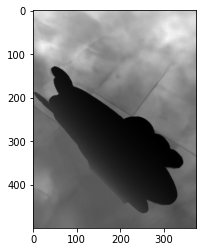

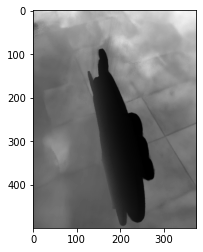

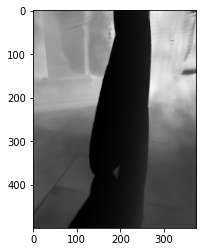

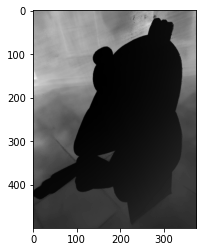

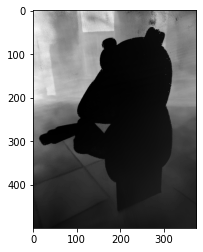

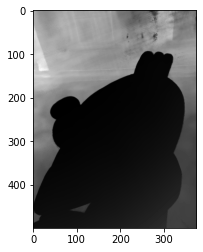

In [46]:
for i,c2w in enumerate(transform_matrices):
  rays_o, rays_d = get_rays_with_dir(val_dataset.dir_cam, c2w[:3, :4])
  rays = torch.cat([rays_o, rays_d, val_dataset.near * torch.ones_like(rays_o[:, :1]), val_dataset.far * torch.ones_like(rays_o[:, :1])], 1)

  depth = []
  for cur_chunk in range(0, rays.shape[0], chunk_size):
      cur_rays = rays[cur_chunk: cur_chunk + chunk_size]
      with torch.no_grad():
          _, cur_results_fine = model(cur_rays.cuda())

      depth.append(cur_results_fine)

  depth = torch.cat(depth, dim = 0)

  normalized_depth = depth / max(depth)
  plt.imshow(normalized_depth.reshape(img_wh[1], img_wh[0]).cpu().numpy(), cmap = 'gray')
  plt.show()